<a href="https://colab.research.google.com/github/ssobranding/mypage/blob/main/WEEK_5_SOLUTIONS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# WEEK 5 SOLUTIONS
Task: compare logistic regression, decision trees and SVM for the credit dataset.

## Business Understanding
*   The company is offering loans to the customers listed in the dataset.
*   The target variable ($Y$) is a binary value (discrete/2-class classification).
*   The business is probably most interested in _precision_. If the company cares most about _recall_ it means that they are more concerned about minimising _false negatives_ ... in this domain that would mean they are __not__ lending money to a customer who would pay it back. Alternatively, focusing on _precision_ means minimising _false positives_. In the business domain this means saying some is good to lend money to when in fact they are "bad" (not able to pay back).
*   From the previous notebooks, we should note that _micro precision_ would basically just be _accuracy_, so we will set the __score__ as __macro precision__.

## Data Understanding and Preparation
*   The data is already cleaned and scaled for modeling.
*   The target ($Y$) is the column 'class'.
*  The target ($Y$) is coded as $0 = good\_loan$ and $1 = bad\_loan$.
*   All we need do here is read the data in, separate the target and then split into training and test:







In [ ]:
from google.colab import files
uploaded = files.upload()

Saving credit_data_final.csv to credit_data_final.csv


In [ ]:
import pandas as pd
import numpy as np

df = pd.read_csv('credit_data_final.csv')
df.head()

,checking_status,duration,credit_amount,savings_status,employment,installment_commitment,residence_since,age,housing,existing_credits,...,type__none,type__life insurance,type__no known property,type__real estate,type__skilled,type__unemp/unskilled non res,type__unskilled resident,type__none.1,type__stores,gender
0,0.333333,0.029412,0.050567,0.00,1.00,1.000000,1.000000,0.857143,1.0,0.333333,...,1,0,0,1,1,0,0,1,0,0
1,0.666667,0.647059,0.313690,0.25,0.50,0.333333,0.333333,0.053571,1.0,0.000000,...,1,0,0,1,1,0,0,1,0,1
2,0.000000,0.117647,0.101574,0.25,0.75,0.333333,0.666667,0.535714,1.0,0.000000,...,1,0,0,1,0,0,1,1,0,0
3,0.333333,0.558824,0.419941,0.25,0.75,0.333333,1.000000,0.464286,0.0,0.000000,...,0,1,0,0,1,0,0,1,0,0
4,0.333333,0.294118,0.254209,0.25,0.50,0.666667,1.000000,0.607143,0.0,0.333333,...,1,0,1,0,1,0,0,1,0,0


In [ ]:
y_value = df['class'] # set the y
y_values = np.ravel(y_value) # change to an array (list)

x_values = df.drop('class', axis=1) # drop the y from the dataframe

In [ ]:
# split data into training and test
from sklearn.model_selection  import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(x_values, y_value, test_size = 0.2, random_state=4567, stratify=y_value)

# print the shapes to check everything is OK
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(800, 28)
(200, 28)
(800,)
(200,)


## Modeling and Evaluation
We will set up algorithms for logistic regression, decision trees and SVM and train.

Just to look at the impact of hyperparameter optimisation, we will set them up initially with default hyperparameters and compare their performance (on the training data):

In [ ]:
from sklearn.linear_model import LogisticRegression as LogR
from sklearn.tree import DecisionTreeClassifier as DTC
from sklearn.svm import SVC
from sklearn.metrics import precision_recall_fscore_support

LogR_algo = LogR()
LogR_model = LogR_algo.fit(X_train, Y_train)

tree_algo = DTC()
tree_model = tree_algo.fit(X_train, Y_train)

SVM_algo = SVC()
SVM_model = SVM_algo.fit(X_train, Y_train)

models = [LogR_model, tree_model, SVM_model]
names = ['Logistic Regression', 'Decision Tree', 'SVM']

for i in range(3):
  print(f"Model: {names[i]}")

  # predict based on training data
  predict = models[i].predict(X_train)

  # Calculate precision, recall, and F1-score
  precision, recall, f1_score, _ = precision_recall_fscore_support(Y_train, predict, average='macro')
  print(f"Macro Precision: {precision}")
  print(f"Macro Recall: {recall}")
  print(f"Macro F1-score: {f1_score}")
  print("\n")


Model: Logistic Regression
Macro Precision: 0.695493494128848
Macro Recall: 0.6145833333333334
Macro F1-score: 0.6216980598450139


Model: Decision Tree
Macro Precision: 1.0
Macro Recall: 1.0
Macro F1-score: 1.0


Model: SVM
Macro Precision: 0.8282289849454029
Macro Recall: 0.6133928571428572
Macro F1-score: 0.6152583646953746




Decision trees look the best - however, we always need to worry about overfitting with this algorithm in particular. SVM seems to perform better on precision (good news) than logistic regression, but other metrics are the same. Let's hyperparameter tune them and see the scores again (on training data):

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

# we get a load of warnings running the code so will supress them
import warnings
warnings.filterwarnings("ignore")

# create a hyperparameter search function for re-usability
def random_search(algo, hyperparameters, X_train, Y_train):
  # do the search using 5 folds/chunks
  clf = RandomizedSearchCV(algo, hyperparameters, cv=5, random_state=2015,
                          scoring='precision_macro', n_iter=20, refit=True)

  # pass the data to fit/train
  clf.fit(X_train, Y_train)

  return clf.best_params_

# Logistic Regression
LogR_tuned_parameters = {
    'solver': ['liblinear'], # only this one as it does both L1 and L2
    'C': uniform(loc=0.1, scale=19.9),  # Draw from a uniform distribution between 0.1 and 20
    'penalty': ['l1', 'l2', 'elasticnet', None]
}

LogR_best_params = random_search(LogR_algo, LogR_tuned_parameters, X_train, Y_train)


# Decision Tree
tree_tuned_parameters = {
    'criterion': ['gini', 'entropy'],
    'max_depth': randint(3, 9),  # Draw from a uniform distribution between 3 and 15
    'min_samples_split': randint(3, 9),  # Draw from a uniform distribution between 2 and 10
    'max_features': ['sqrt', 'log2', None]
}

tree_best_params = random_search(tree_algo, tree_tuned_parameters, X_train, Y_train)


# SVM
SVM_tuned_parameters = {
    'C': uniform(loc=0.1, scale=19.9),  # Draw from a uniform distribution between 0.1 and 20
    'kernel': ['linear', 'poly', 'rbf'],
    'gamma': [1e-2, 1e-3, 1e-4, 1e-5]
}

SVM_best_params = random_search(SVM_algo, SVM_tuned_parameters, X_train, Y_train)


# Train the models
LogR_algo = LogR(**LogR_best_params)
LogR_model = LogR_algo.fit(X_train, Y_train)

tree_algo = DTC(**tree_best_params)
tree_model = tree_algo.fit(X_train, Y_train)

SVM_algo = SVC(**SVM_best_params)
SVM_model = SVM_algo.fit(X_train, Y_train)


# score the models
models = [LogR_model, tree_model, SVM_model] # redo this or it uses the old models

for i in range(3):
  print(f"Model: {names[i]}")

  # predict based on training data
  predict = models[i].predict(X_train)

  # Calculate precision, recall, and F1-score
  precision, recall, f1_score, _ = precision_recall_fscore_support(Y_train, predict, average='macro')
  print(f"Macro Precision: {precision}")
  print(f"Macro Recall: {recall}")
  print(f"Macro F1-score: {f1_score}")
  print("\n")

Model: Logistic Regression
Macro Precision: 0.6981523631008166
Macro Recall: 0.6211309523809524
Macro F1-score: 0.629761289933129


Model: Decision Tree
Macro Precision: 0.7235772357723578
Macro Recall: 0.6571428571428571
Macro F1-score: 0.6710526315789473


Model: SVM
Macro Precision: 0.6643835616438356
Macro Recall: 0.5625
Macro F1-score: 0.5478869717429358




Our scores all look lower 😞

However ... this is scores on training data and we have predicted our training data and this time (probably) increased regularisation. To score lower should be expected.

With this done we can now test all three against our test data (which is the real test):

In [ ]:
for i in range(3):
  print(f"Model: {names[i]}")

  # predict based on TEST data
  predict = models[i].predict(X_test)

  # Calculate precision, recall, and F1-score
  precision, recall, f1_score, _ = precision_recall_fscore_support(Y_test, predict, average='macro')
  print(f"Macro Precision: {precision}")
  print(f"Macro Recall: {recall}")
  print(f"Macro F1-score: {f1_score}")
  print("\n")

Model: Logistic Regression
Macro Precision: 0.6376488095238095
Macro Recall: 0.5880952380952381
Macro F1-score: 0.590626764539808


Model: Decision Tree
Macro Precision: 0.6190476190476191
Macro Recall: 0.5761904761904761
Macro F1-score: 0.5765104460756635


Model: SVM
Macro Precision: 0.6541145681884268
Macro Recall: 0.5630952380952381
Macro F1-score: 0.550455459600142




Given our preferred metric is precison we would probably prefer SVM. However, precision is not much higher than Logistic Regressionit does score lower slightly on recall and F1 so both seem like reasonable choices. Let's look at the confusion matricies for each to make a final decision:

Logistic Regression Confusion Matrix


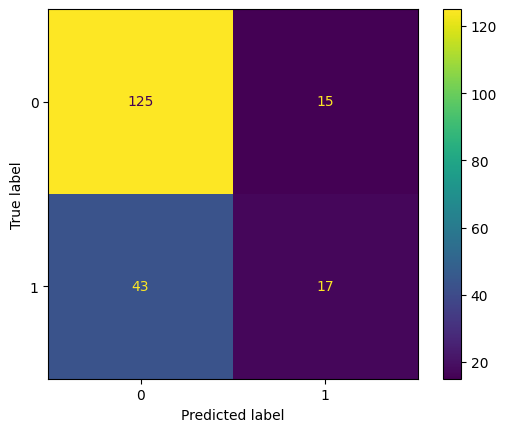

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay as CM

# Logistic Regression
print("Logistic Regression Confusion Matrix")
predict = LogR_model.predict(X_test)
CM.from_predictions(Y_test, predict)

SVM Confusion Matrix


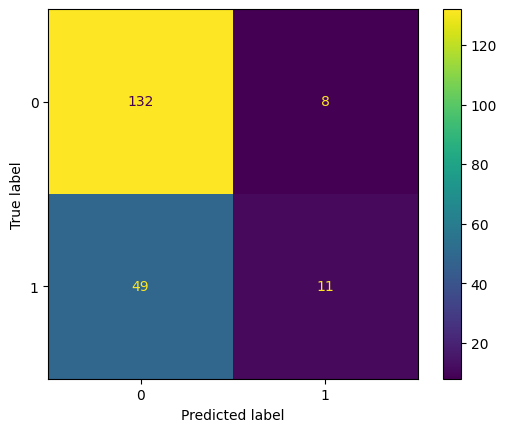

In [ ]:
# SVM
print("SVM Confusion Matrix")
predict = SVM_model.predict(X_test)
print(CM.from_predictions(Y_test, predict))

Although the scores are similar we can see they are wrong in different ways. Because we care most about minimising cases we predict 0 (good to loan to) and in fact they are a 1 (bad to loan to), Logistic Regression should be best. SVM misclassifies 49 cases in this way, while Logistic Regression only 43.

So Logistic Regression is the winner.

However ... we may note that actually the model probably needs more work. Giving out 43 bad loans out of 168 is probably too high a ratio. Stay tuned as we will discuss some methods to troubleshoot models later in the module!

